In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import joblib


In [2]:


train_df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\archive\CICIOT23\train\train.csv')
test_df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\archive\CICIOT23\test\test.csv')
val_df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\archive\CICIOT23\validation\validation.csv')

# Print shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", val_df.shape)



Train shape: (5491971, 47)
Test shape: (1176851, 47)
Validation shape: (1176851, 47)


In [3]:
train_normal = train_df[train_df['label'] == "BenignTraffic"].copy()
val_normal   = val_df[val_df['label'] == "BenignTraffic"].copy()


In [4]:
numeric_features = train_normal.select_dtypes(include=[np.number]).columns.tolist()

print("Number of numeric features:", len(numeric_features))


Number of numeric features: 46


In [5]:
scaler = MinMaxScaler()
scaler.fit(train_normal[numeric_features])

X_train = scaler.transform(train_normal[numeric_features])
X_val   = scaler.transform(val_normal[numeric_features])
X_test  = scaler.transform(test_df[numeric_features])


In [6]:
timesteps = X_train.shape[1]
n_features = 1 # Each of the 46 values is treated as a single feature over 46 timesteps

# Reshape data to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_val = X_val.reshape(X_val.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(n_features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 46, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 46, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, X_train,
    epochs=15,
    batch_size=512,
    validation_data=(X_val, X_val),
    callbacks=[es],
    verbose=2
)


Epoch 1/15
254/254 - 40s - 157ms/step - loss: 0.1190 - val_loss: 0.1170
Epoch 2/15
254/254 - 33s - 131ms/step - loss: 0.1152 - val_loss: 0.1235
Epoch 3/15
254/254 - 33s - 132ms/step - loss: 0.1179 - val_loss: 0.1123
Epoch 4/15
254/254 - 34s - 134ms/step - loss: 0.1190 - val_loss: 0.1127
Epoch 5/15
254/254 - 34s - 134ms/step - loss: 0.1170 - val_loss: 0.1202
Epoch 6/15
254/254 - 34s - 135ms/step - loss: 0.1195 - val_loss: 0.1211
Epoch 7/15
254/254 - 34s - 135ms/step - loss: 0.1056 - val_loss: 0.0980
Epoch 8/15
254/254 - 35s - 138ms/step - loss: 0.0914 - val_loss: 0.0881
Epoch 9/15
254/254 - 37s - 146ms/step - loss: 0.0618 - val_loss: 0.0504
Epoch 10/15
254/254 - 37s - 146ms/step - loss: 0.0348 - val_loss: 0.0333
Epoch 11/15
254/254 - 37s - 146ms/step - loss: 0.0215 - val_loss: 0.0258
Epoch 12/15
254/254 - 35s - 136ms/step - loss: 0.0173 - val_loss: 0.0276
Epoch 13/15
254/254 - 34s - 136ms/step - loss: 0.0271 - val_loss: 0.0106
Epoch 14/15
254/254 - 34s - 136ms/step - loss: 0.0157 - val_

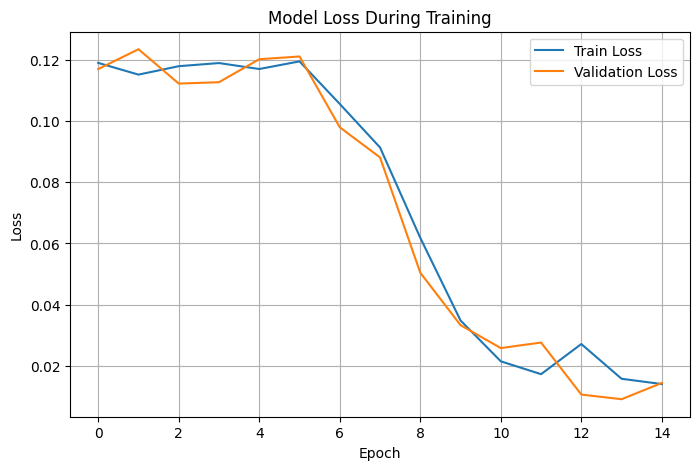

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
val_pred = model.predict(X_val, batch_size=1024)
val_mae  = np.mean(np.abs(val_pred - X_val), axis=(1,2))

threshold = np.percentile(val_mae, 95)  # Top 5% errors considered anomalies
print("Threshold:", threshold)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Threshold: 0.08259031421949804


In [10]:
test_pred = model.predict(X_test, batch_size=1024)
test_mae  = np.mean(np.abs(test_pred - X_test), axis=(1,2))


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 67s 58ms/step


In [11]:
y_test = (test_df['label'] != "BenignTraffic").astype(int).values


In [12]:
y_pred = (test_mae > threshold).astype(int)


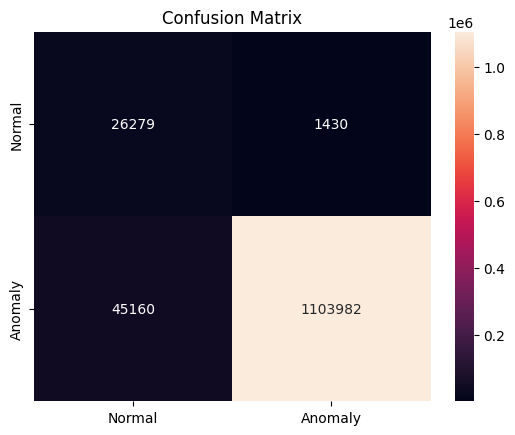

              precision    recall  f1-score   support

      Normal       0.37      0.95      0.53     27709
     Anomaly       1.00      0.96      0.98   1149142

    accuracy                           0.96   1176851
   macro avg       0.68      0.95      0.75   1176851
weighted avg       0.98      0.96      0.97   1176851



In [13]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Normal","Anomaly"],
            yticklabels=["Normal","Anomaly"])
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Normal","Anomaly"]))
